# Preprocessing Module with Features Data
This module adds the target column of laterality to features data according to
MDS-UPDRS patients test.

## Required Imports

In [1]:
import os
import re


import pandas as pd
import numpy as np
import seaborn as sns

from src.settings import ROOT_DIR
from src.preprocessing.get_anon_id import get_anon_id
from src.utils.data_split import save_and_split

## Load Data
Loads Features and MDS-UPDRS

In [2]:
#Load Features
data: pd.DataFrame = pd.read_pickle(ROOT_DIR / 'data' / 'processed' / 'anon_imu_data_features.pkl')

#Load MDS-UPDRS
patients_mds: pd.DataFrame = pd.read_excel(ROOT_DIR / 'data' / 'raw' / 'imus y marcha (1).xlsx')
patients_mds_used_columns = ['CC','Laterality']
patients_mds = patients_mds[patients_mds_used_columns]

In [3]:
patients_mds.dropna(inplace=True)

In [4]:
patients_mds['CC'] = patients_mds['CC'].astype(int)
patients_mds['CC'] = patients_mds['CC'].astype('string')
patients_mds['Laterality'] = patients_mds['Laterality'].astype(int)

## MDS-UPDRS Target extraction

Is necessary to split patients and controls to cross ids with MDS-UPDRS test:

In [5]:
patients_mds['anon_id'] = patients_mds['CC'].apply(get_anon_id)
patients_mds_used_columns.pop(0)

'CC'

In [6]:
patients_mds.dropna(inplace=True)

In [7]:
patients_mds['laterality'] = patients_mds['Laterality']
patients_mds = patients_mds[['anon_id', 'laterality']]

In [8]:
patients_mds = patients_mds[patients_mds['anon_id'].ne('')]

In [9]:
patients_mds

,anon_id,laterality
0,182,1
1,176,1
2,184,2
3,67,2
6,173,1
...,...,...
127,85,1
128,68,0
135,14,1
149,92,0


In [10]:
patients_mds['laterality'].value_counts()

laterality
1    50
2    42
0    10
Name: count, dtype: int64

In [11]:
patients = data[data['PD'] == 1].copy()
controls = data[data['PD'] == 0].copy()

In [12]:
len(patients)

10284

In [13]:
mds_id_list = set(patients_mds['anon_id'].tolist())
df_id_list = set(patients['anon_id'].tolist())
intersection_ids = df_id_list.intersection(mds_id_list)
print(len(intersection_ids))

78


In [14]:
patients_mds = patients_mds[patients_mds['anon_id'].isin(intersection_ids)]

In [15]:
print('Patients registers before merge:',len(patients))
patients = pd.merge(patients, patients_mds, how='inner')
patients.dropna(inplace=True)
print('Patients registers after merge:',len(patients))

Patients registers before merge: 10284
Patients registers after merge: 10280


In [16]:
controls['laterality'] = [0 for i in range(len(controls))]

In [17]:
laterality_data = pd.concat([patients, controls])

In [18]:
len(laterality_data)

19746

In [19]:
laterality_data['laterality'].value_counts()

laterality
0    10686
1     5105
2     3955
Name: count, dtype: int64

In [22]:
laterality_data['laterality'] = laterality_data['laterality'].replace(2, 1)
laterality_data['laterality'].value_counts()

laterality
0    10686
1     9060
Name: count, dtype: int64

## Feature Selection

In [23]:
temp = laterality_data[laterality_data.columns.tolist()[4:]].copy()

In [24]:
correlation = laterality_data[laterality_data.columns.tolist()[4:]].corr().abs()['laterality']

In [26]:
correlation=correlation.sort_values(ascending=False)

In [27]:
correlation

laterality                              1.000000
PD                                      0.883575
imu_gyroZ_spine_mean_abs_dev            0.330761
imu_gyroZ_spine_median_abs_dev          0.319338
imu_gyroZ_spine_std                     0.319285
                                          ...   
imu_angleX_spine_std                    0.001421
imu_angularZ_right_mean                 0.000868
imu_accY_right_positive_count           0.000849
imu_angleZ_spine_interquartile_range    0.000761
imu_angularX_left_mean                  0.000489
Name: laterality, Length: 542, dtype: float64

In [28]:
best_correlations_columns = []
for index, value in correlation.items():
    if value > 0.27:
        best_correlations_columns.append(index)

best_correlations_columns

['laterality',
 'PD',
 'imu_gyroZ_spine_mean_abs_dev',
 'imu_gyroZ_spine_median_abs_dev',
 'imu_gyroZ_spine_std',
 'imu_gyroZ_spine_interquartile_range',
 'imu_angleZ_left_range',
 'imu_angleZ_left_std',
 'imu_angleZ_left_mean_abs_dev',
 'imu_gyroZ_left_min',
 'imu_gyroZ_left_mean_abs_dev',
 'imu_angleZ_left_max',
 'imu_gyroZ_left_interquartile_range',
 'imu_gyroZ_left_std',
 'imu_angleZ_left_min',
 'imu_accY_left_median',
 'imu_accZ_spine_positive_count',
 'imu_accZ_spine_negative_count',
 'imu_angleZ_left_interquartile_range',
 'imu_gyroZ_left_range',
 'imu_gyroZ_left_median_abs_dev',
 'imu_angleX_left_min',
 'imu_gyroZ_spine_range',
 'imu_angleZ_left_median_abs_dev']

In [29]:
len(best_correlations_columns)

24

<Axes: >

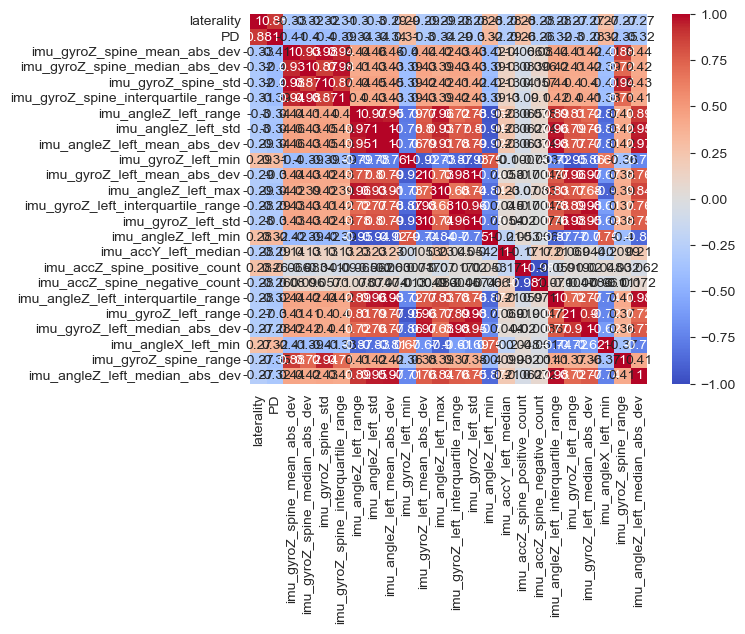

In [30]:
laterality_data = laterality_data[best_correlations_columns]
sns.heatmap(laterality_data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

### Drop of highly correlated columns

In [32]:
correlation = laterality_data.corr().abs()
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['imu_gyroZ_spine_std',
 'imu_gyroZ_spine_interquartile_range',
 'imu_angleZ_left_std',
 'imu_angleZ_left_mean_abs_dev',
 'imu_angleZ_left_max',
 'imu_gyroZ_left_interquartile_range',
 'imu_gyroZ_left_std',
 'imu_angleZ_left_min',
 'imu_accZ_spine_negative_count',
 'imu_angleZ_left_interquartile_range',
 'imu_gyroZ_left_range',
 'imu_gyroZ_left_median_abs_dev',
 'imu_angleZ_left_median_abs_dev']

In [33]:
correlation['laterality'].sort_values()

imu_angleZ_left_median_abs_dev         0.270988
imu_gyroZ_spine_range                  0.271588
imu_angleX_left_min                    0.272962
imu_gyroZ_left_median_abs_dev          0.273648
imu_gyroZ_left_range                   0.274712
imu_angleZ_left_interquartile_range    0.275926
imu_accZ_spine_negative_count          0.279786
imu_accZ_spine_positive_count          0.280813
imu_accY_left_median                   0.280994
imu_angleZ_left_min                    0.283690
imu_gyroZ_left_std                     0.283999
imu_gyroZ_left_interquartile_range     0.284779
imu_angleZ_left_max                    0.287764
imu_gyroZ_left_mean_abs_dev            0.287808
imu_gyroZ_left_min                     0.288271
imu_angleZ_left_mean_abs_dev           0.293233
imu_angleZ_left_std                    0.297692
imu_angleZ_left_range                  0.297938
imu_gyroZ_spine_interquartile_range    0.313062
imu_gyroZ_spine_std                    0.319285
imu_gyroZ_spine_median_abs_dev         0

In [34]:
len(to_drop)

13

In [35]:
laterality_data.drop(to_drop, axis=1, inplace=True)

In [36]:
#PD is not the target of this module so it will be deleted
laterality_data.drop(columns=['PD'], inplace=True)

<Axes: >

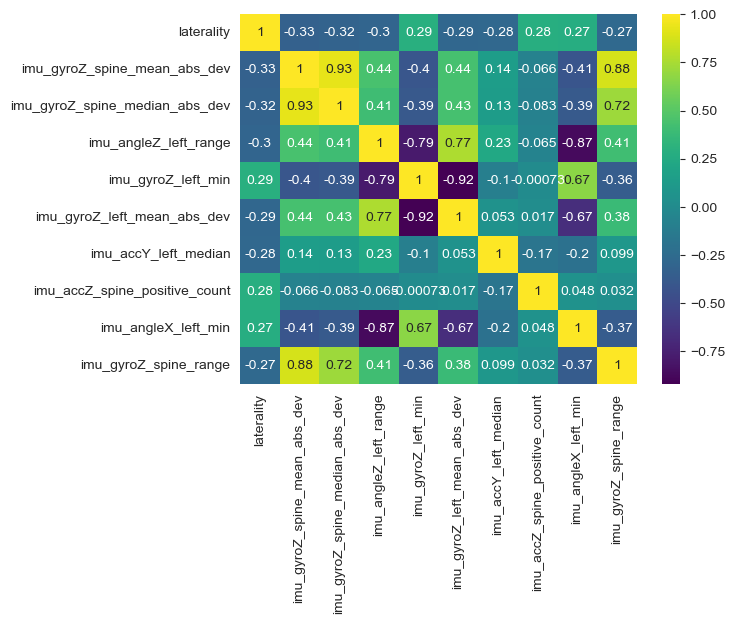

In [37]:
sns.heatmap(laterality_data.corr(), annot = True, cmap= 'viridis')

## Features Mirroring
Due to the chosen features only focused on left limb and spine, is necessary to keep on mind that a patient could
have laterality on his right limb and using the selected features is not possible to identify that PD symptom. As
an alternative for this problem we will add all the symmetric features (if mean_left is present, then mean_right 
will also be included)

In [38]:
pattern_left = re.compile(".*.left")
left_cols = list(filter(pattern_left.match, laterality_data.columns.tolist()))
right_cols = [col.replace('left', 'right') for col in left_cols]

for col in right_cols:
    laterality_data[col] = temp[col]

In [39]:
laterality_data.columns

Index(['laterality', 'imu_gyroZ_spine_mean_abs_dev',
       'imu_gyroZ_spine_median_abs_dev', 'imu_angleZ_left_range',
       'imu_gyroZ_left_min', 'imu_gyroZ_left_mean_abs_dev',
       'imu_accY_left_median', 'imu_accZ_spine_positive_count',
       'imu_angleX_left_min', 'imu_gyroZ_spine_range',
       'imu_angleZ_right_range', 'imu_gyroZ_right_min',
       'imu_gyroZ_right_mean_abs_dev', 'imu_accY_right_median',
       'imu_angleX_right_min'],
      dtype='object')

In [40]:
laterality_col = laterality_data.pop('laterality')
laterality_data.insert(len(laterality_data.columns), 'laterality', laterality_col)

<Axes: >

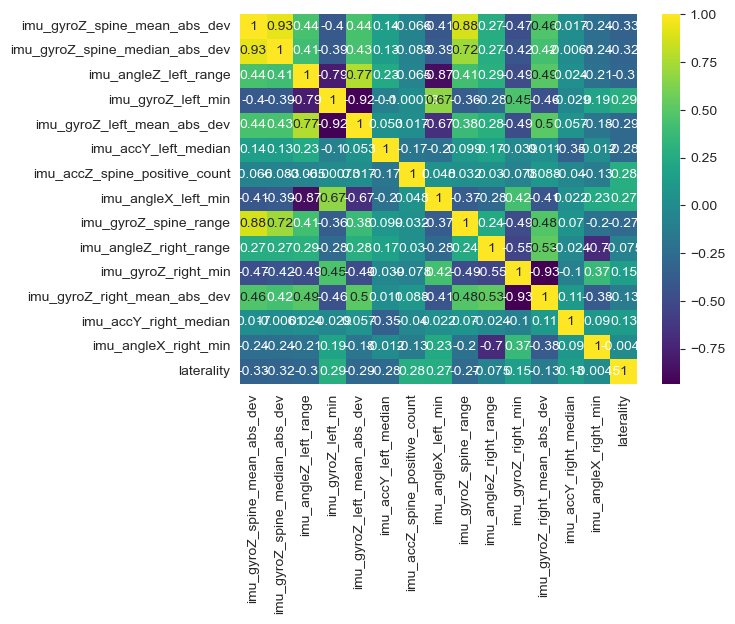

In [41]:
sns.heatmap(laterality_data.corr(), annot = True, cmap= 'viridis')

## Save data

In [42]:
save_path = str(ROOT_DIR) + '/data/processed/asa-features/'
os.makedirs(save_path, exist_ok=True)

save_and_split(laterality_data, 'asa-features')